In [1]:
log_flows = True

In [2]:
%%time
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from copy import deepcopy,copy
from ipywidgets import IntProgress
from itertools import chain
from IPython.display import display
from datetime import datetime
import pickle
import os
# Since the 'user' column do not have relevant information will not be read

# Import Machine Scientist
from importlib.machinery import SourceFileLoader
path = f'{os.getcwd()}/rguimera-machine-scientist/machinescientist.py'
ms = SourceFileLoader('ms', path).load_module()

states=['New York','Massachusetts','California','Florida','Washington','Texas']
scatter_models={s:{} for s in states}
error_models={s:{} for s in states}

CPU times: user 1.2 s, sys: 715 ms, total: 1.91 s
Wall time: 3.37 s


In [3]:
def get_train_test(features):
    import random
    name_unique = np.unique(list(features.name_o)+list(features.name_d))
    random.shuffle(name_unique)
    split = len(name_unique) // 2
    name_train = name_unique[:split]
    name_test = name_unique[split:]
    
    train_data = features[(features.name_o.isin(name_train))&(features.name_d.isin(name_train))]
    test_data = features[(features.name_o.isin(name_test))&(features.name_d.isin(name_test))]
    return train_data,test_data
def delete_nan(a,b):
    a_new=[i for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    b_new=[j for i,j in zip(a,b) if i>0. and i<np.inf and j>0. and j<np.inf and i!=np.nan and j!=np.nan]
    return a,b#a_new,b_new
def common_part_of_commuters(values1, values2):
    values1,values2=delete_nan(values1,values2)
    tot = np.sum(values1) + np.sum(values2)
    return 2.0 * np.sum(np.minimum(values1, values2)) / tot
def common_part_of_commuters_accuracy(real, predicted):
    real,predicted=delete_nan(real,predicted)
    tot = 2.*np.sum(real)
    return 2.0 * np.sum(np.minimum(real,predicted)) / tot
def RMSE(real,predicted):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=delete_nan(real,predicted)
    return np.sqrt(np.square(np.subtract(real,predicted)).mean())
def MRE(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return np.array(list(np.abs((y-y1)/y1) for y,y1 in zip(predicted,real))).mean()
def MLogRatio(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return np.array(list(np.abs(np.log(y1/y)) for y,y1 in zip(predicted,real))).mean()
def AbsErr(real,predicted):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=delete_nan(real,predicted)
    return np.abs(np.subtract(real,predicted))
def RE(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return [np.abs((y-y1)/y1) for y,y1 in zip(predicted,real)]
def LogRatio(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return [np.abs(np.log(y1/y)) for y,y1 in zip(predicted,real)]
def ensemble_prediction_median_multidf(list_models,data,key):
    ens_pred=[]
    for i,x in data.iterrows():
        res=[]
        df=pd.DataFrame(x).transpose()
        for model in list_models:
            res1=model.predict({key:df})[key]
            if np.iscomplex(res1.values[0])==False:
                res.append(res1.values[0])
        if log_flows==True:
            median=np.nanmedian(np.exp(res))
        else:
            median=np.nanmedian(res)
        ens_pred.append(median)
    return ens_pred

### Train/Test

In [4]:
name=open('./data/checkpoints/fold1_sample_dataframes_2022_11_02-02_54_03.pkl', "rb")
sample_train=pickle.load(name)
name.close()
#
name=open('./data/checkpoints/fold2_dataframes_2022_11_02-02_54_03.pkl', "rb")
test=pickle.load(name)
name.close()
#
name=open('./data/checkpoints/list_states_dataframes_2022_11_02-02_53_58.pkl', "rb")
list_states_dataframes=pickle.load(name)
name.close()
"""
for i,key in enumerate(states):
    print(sample_train[key][sample_train[key].duplicated(subset=['name_o', 'name_d'],keep=False)])
    print(test[key][test[key].duplicated(subset=['name_o', 'name_d'],keep=False)])
    print(list_states_dataframes[i][list_states_dataframes[i].duplicated(subset=['name_o', 'name_d'],keep=False)])
"""    
#
train_list_dataframes=sample_train
#
test_list_dataframes=test
#
x_train_list_sample=deepcopy(sample_train)
#
y_train_list_sample=deepcopy({key:item['total_pop_flow'] for key,item in sample_train.items()})
#
for state in states:
    df=test_list_dataframes[state]
    test_labels = np.array(df['total_pop_flow'])
    scatter_models[state]['test']=deepcopy(test_labels)

In [5]:
economic_stats={key:deepcopy(df[['total_pop_flow','name_o','name_d','m_o','m_d']]) for key,df in test.items()}

median_income_person={
    'New York':35379,'Massachusetts':39666,'California':33719,'Florida':29159,'Washington':37656,'Texas':31462
}

city_status={}

for key,df in economic_stats.items():
    
    name=open(f'./data/{key.replace(" ", "")}/income.pkl', "rb")
    city_income=pickle.load(name)
    name.close()
    # Median income
    print(np.average(list(city_income.values())))
    print(np.median(list(city_income.values())))
    mean=np.average(list(city_income.values()))
    def return_class(name,p):
        if name not in city_income.keys():
            return ''
        income=city_income[name]
        if income>p:
            return 'rich'
        else:
            return 'poor'
    df['status']=df.apply(lambda row: return_class(row.name_o,median_income_person[key])+'-'+return_class(row.name_d,median_income_person[key]),axis=1)
    
    cities=np.unique(df[['name_o', 'name_d']].values)
    city_status[key]={name:return_class(name,median_income_person[key]) for name in cities}
    
    print(df.head())
    print(len(df[df.status=='poor-poor']))
    print(len(df[df.status=='rich-rich']))
    print(len(df[df.status=='rich-poor']))
    print(len(df[df.status=='poor-rich']))

38361.233502538074
34760.0
     total_pop_flow    name_o          name_d    m_o    m_d     status
0            1213.0  Altamont          Albany   1675  99224  rich-poor
3             544.0  Altamont     Schenectady   1675  67047  rich-poor
4              99.0  Altamont  East Glenville   1675  11896  rich-rich
6            1164.0  Altamont        Westmere   1675   7560  rich-rich
118            90.0  Lockport  East Rochester  20876   6334  poor-poor
524
3647
939
842
41446.27731092437
40254.5
   total_pop_flow            name_o      name_d    m_o     m_d     status
0            69.0  Southbridge Town  Framingham  17740   72362  poor-rich
4            91.0  Southbridge Town     Chelsea  17740   40787  poor-poor
6          7592.0  Southbridge Town   Worcester  17740  206518  poor-poor
7           358.0  Southbridge Town    Chicopee  17740   55560  poor-poor
8           146.0  Southbridge Town     Holyoke  17740   38238  poor-poor
285
350
233
312
35871.74173971679
31708.0
   total_pop_flow 

# Deep Gravity

35063.0 15320.147
20.0 0.008805959
5952 5952
5952
Model metrics:New York
CPC: 0.5276658935147177
Acc: 0.37756055200832994
RMSE: 1270.9889
RE: 0.75385416
DL(train): 1.3384765
55499.0 24064.254
9.0 0.009131461
1180 1180
1180
Model metrics:Massachusetts
CPC: 0.49464627851883625
Acc: 0.33692738209663936
RMSE: 1908.8029
RE: 0.69622
DL(train): 1.3272232
416696.0 373559.94
2.0 0.009119432
11727 11727
11727
Model metrics:California
CPC: 0.5667349828155551
Acc: 0.45209839616971137
RMSE: 7224.5225
RE: 0.9866854
DL(train): 1.5844328
79624.0 195326.67
3.0 0.05355005
7092 7092
7092
Model metrics:Florida
CPC: 0.6237393309163749
Acc: 0.516291082813472
RMSE: 3083.9443
RE: 0.890769
DL(train): 1.3331136
54245.0 92047.89
12.0 0.00016496003
2083 2083
2083
Model metrics:Washington
CPC: 0.5481552005247753
Acc: 0.4413915055808066
RMSE: 3063.4949
RE: 1.0819049
DL(train): 1.3678672
112865.0 41107.152
3.0 6.478473e-06
2782 2782
2782
Model metrics:Texas
CPC: 0.4499483363899544
Acc: 0.3060665433109783
RMSE: 2677.

New York Massachusetts   California      Florida  \
Deep Gravity CPC           0.527666      0.494646     0.566735     0.623739   
             ACC           0.377561      0.336927     0.452098     0.516291   
             RMSE       1270.988892   1908.802856  7224.522461  3083.944336   
             RE            0.753854       0.69622     0.986685     0.890769   
             LR            1.338477      1.327223     1.584433     1.333114   
             DL(train)            -             -            -            -   

                         Washington        Texas  
Deep Gravity CPC           0.548155     0.449948  
             ACC           0.441392     0.306067  
             RMSE       3063.494873  2677.721924  
             RE            1.081905     1.128941  
             LR            1.367867     3.465785  
             DL(train)            -            -

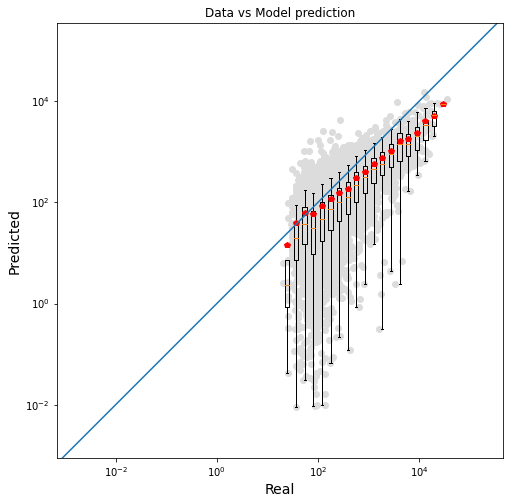

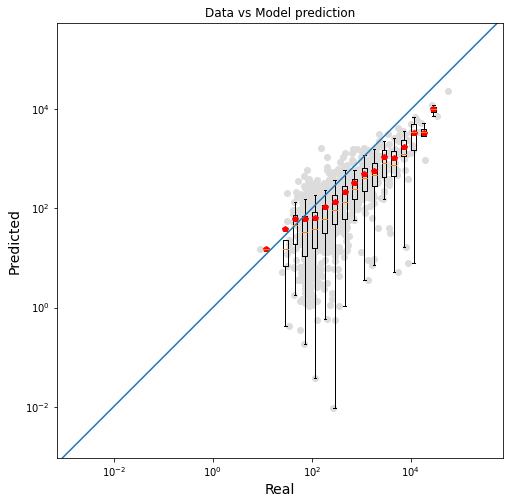

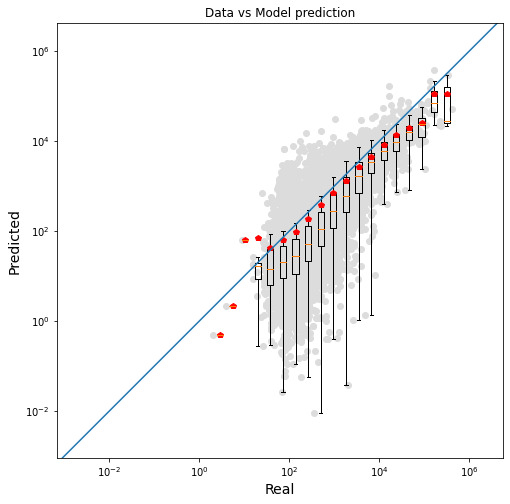

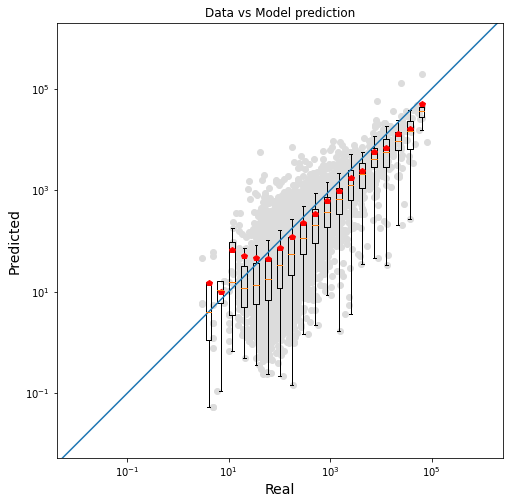

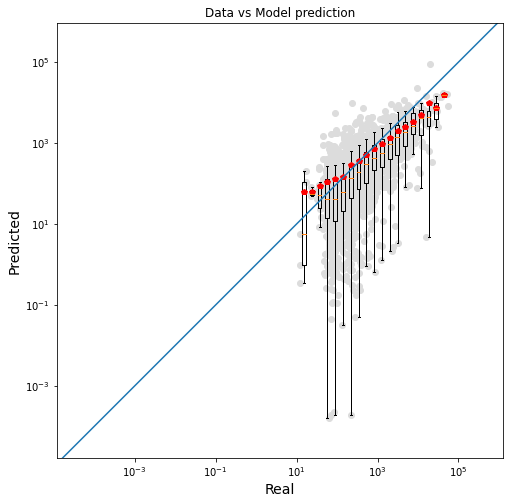

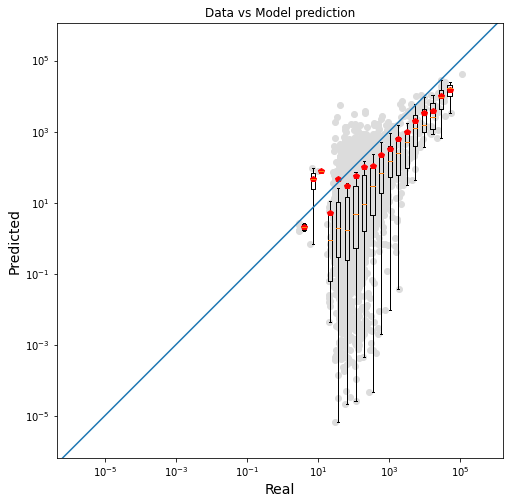

In [6]:
res={}
files={'New York':""}
for i,key in enumerate(states):
    if key=='New York':
        name='NewYork'
    else:
        name=key
    df=pd.read_pickle(f'./DeepGravity/results/fluxos_DG_{name}.pkl')
    
    
    test_labels=[]
    predictions=[]
    for j,k in zip(df.data,df.target):
        for l,m in zip(j,k):
            if l==float('Nan') or m==float('Nan'):
                print('Nan',l,m)
            if m<0.:
                print('Negative',l,m)
            if l>0.0:
                test_labels.append(l)
                predictions.append(m)
    print(max(test_labels),max(predictions))
    print(min(test_labels),min(predictions))
    #if log_flows==True:
    #    predictions=np.exp(predictions)
    print(len(test_labels),len(predictions))
    print(len(scatter_models[key]['test']))
    scatter_models[key]['Deep Gravity']=deepcopy(predictions)
    scatter_models[key]['testDG']=deepcopy(test_labels)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              '-'
             ]
    error_models[key]['Deep Gravity']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['Deep Gravity']=predictions

    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

DG = pd.DataFrame(res,index=[['Deep Gravity', 'Deep Gravity', 'Deep Gravity', 'Deep Gravity', 'Deep Gravity', 'Deep Gravity'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(DG)

## Radiation Model

5952 5952
Model metrics:New York
CPC: 0.42953236614410073
Acc: 0.45444064778343596
RMSE: 2968.750738944294
RE: 1.250460708963481
DL(train): 2.9538816500770215
1180 1180
Model metrics:Massachusetts
CPC: 0.556049667768307
Acc: 0.5936624081983549
RMSE: 2701.943388387967
RE: 1.2050448247363221
DL(train): 1.9729913085526452
11727 11727
Model metrics:California
CPC: 0.4919583022730578
Acc: 0.4528316234780628
RMSE: 8400.231715149082
RE: 1.2827677614148745
DL(train): 2.913085413133246
7092 7092
Model metrics:Florida
CPC: 0.48164113782793627
Acc: 0.45046380016247783
RMSE: 4068.916601354425
RE: 1.2012055542692077
DL(train): 2.8173111868835927
2083 2083
Model metrics:Washington
CPC: 0.45450923930079545
Acc: 0.438352910109983
RMSE: 3697.7503942686235
RE: 1.761491443963729
DL(train): 2.4076292325208257
2782 2782
Model metrics:Texas
CPC: 0.4713724936826106
Acc: 0.4851709482180486
RMSE: 4031.5597872459853
RE: 2.0369767200702094
DL(train): 3.4462862486302566


New York Massachusetts   California      Florida  \
Radiation CPC           0.429532       0.55605     0.491958     0.481641   
          ACC           0.454441      0.593662     0.452832     0.450464   
          RMSE       2968.750739   2701.943388  8400.231715  4068.916601   
          RE            1.250461      1.205045     1.282768     1.201206   
          LR            2.953882      1.972991     2.913085     2.817311   
          DL(train)            -             -            -            -   

                      Washington        Texas  
Radiation CPC           0.454509     0.471372  
          ACC           0.438353     0.485171  
          RMSE       3697.750394  4031.559787  
          RE            1.761491     2.036977  
          LR            2.407629     3.446286  
          DL(train)            -            -

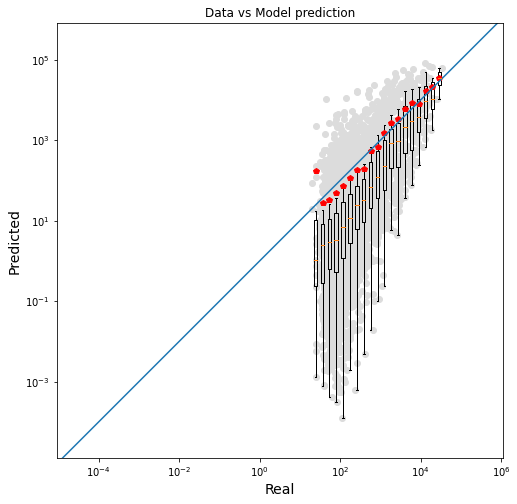

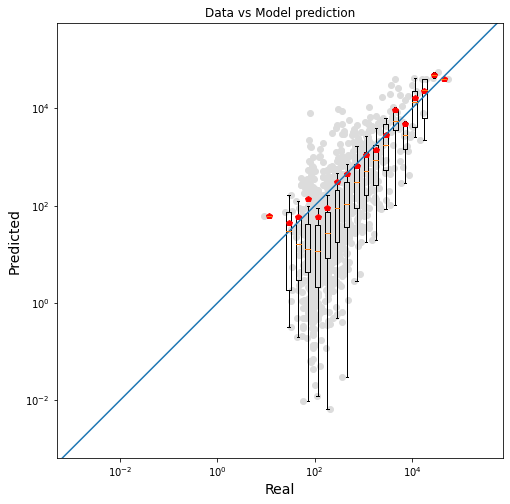

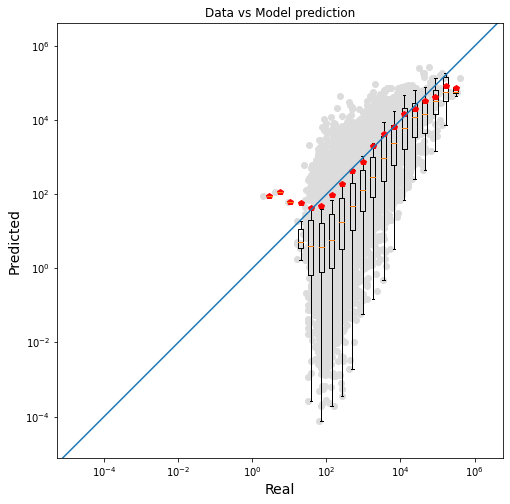

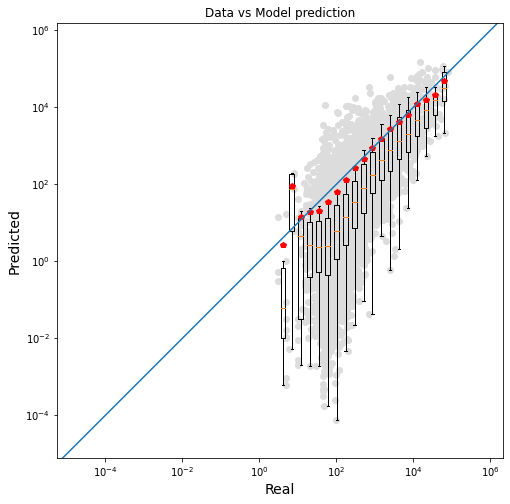

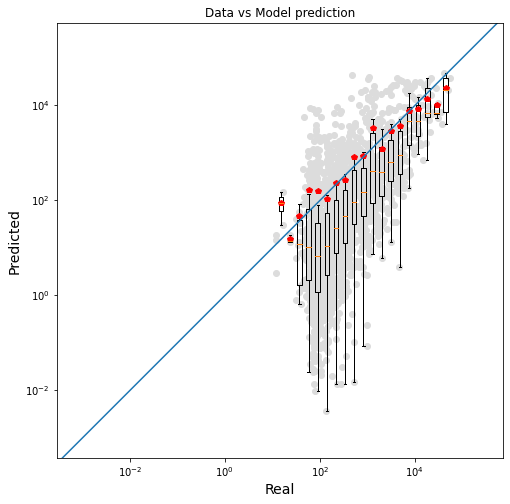

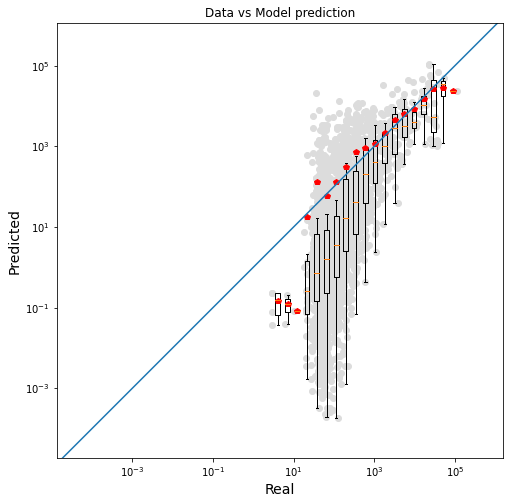

In [7]:
res={}
def radiation_model(dataset,row):
    row=row[1]
    origin=row.name_o
    T_i=np.sum(dataset[dataset.name_o==origin].total_pop_flow.values)
    R=T_i*(row.m_o*row.m_d)/((row.m_o+row.s)*(row.m_o+row.m_d+row.s))
    #R=T_i*((1/(1.+(row.s/row.m_o)))-(1/(1.+((row.s+row.m_d)/row.m_o))))
    if log_flows==True:
        return np.log(R)
    else:
        return R
for i,(key,df) in enumerate(test_list_dataframes.items()):
    test_labels=[]
    predictions=[]
    for row in df.iterrows():
        test_labels.append(row[1].total_pop_flow)
        predictions.append(radiation_model(list_states_dataframes[i],row))
    if log_flows==True:
        predictions=np.exp(predictions)
    print(len(test_labels),len(predictions))
    scatter_models[key]['Radiation']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              '-'
             ]
    error_models[key]['Radiation']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['Radiation']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

Rad = pd.DataFrame(res,index=[['Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(Rad)

# RANDOM FOREST: One model for state

Flows and features Shape: (1000, 46)
Variable: d                    Importance: 0.288595
Variable: transport_poly_d     Importance: 0.066058
Variable: commercial_landuse_d Importance: 0.045425
Variable: food_poly_d          Importance: 0.036859
Variable: retail_landuse_d     Importance: 0.036444
Variable: main_road_line_o     Importance: 0.030965
Variable: residential_landuse_o Importance: 0.030119
Variable: m_o                  Importance: 0.027164
Variable: entertainment_poly_o Importance: 0.024853
Variable: main_road_line_d     Importance: 0.024658
Variable: retail_poly_d        Importance: 0.023529
Variable: retail_point_d       Importance: 0.02119
Variable: school_poly_o        Importance: 0.018338
Variable: school_poly_d        Importance: 0.017576
Variable: retail_point_o       Importance: 0.017514
Variable: food_point_d         Importance: 0.017188
Variable: retail_poly_o        Importance: 0.015842
Variable: health_poly_o        Importance: 0.015693
Variable: entertainment_poi

Model metrics:Florida
CPC: 0.4908037321365665
Acc: 0.3539452341093529
RMSE: 3188.980614070946
RE: 1.0449603202551212
DL(train): 0.7197224478593478
Flows and features Shape: (1000, 46)
Variable: d                    Importance: 0.366864
Variable: transport_poly_d     Importance: 0.096173
Variable: food_point_d         Importance: 0.046466
Variable: retail_poly_d        Importance: 0.032822
Variable: main_road_line_o     Importance: 0.027675
Variable: food_poly_d          Importance: 0.024707
Variable: commercial_landuse_d Importance: 0.022142
Variable: retail_landuse_d     Importance: 0.021005
Variable: entertainment_poly_o Importance: 0.020933
Variable: retail_poly_o        Importance: 0.019891
Variable: m_o                  Importance: 0.01894
Variable: transport_poly_o     Importance: 0.017732
Variable: retail_point_d       Importance: 0.016797
Variable: entertainment_poly_d Importance: 0.015755
Variable: school_poly_o        Importance: 0.015734
Variable: transport_point_o    Import

New York Massachusetts   California      Florida  \
Random Forest CPC           0.549172      0.573138     0.401553     0.490804   
              ACC           0.434492      0.475632     0.267174     0.353945   
              RMSE       1404.533689   2268.421804  8935.178404  3188.980614   
              RE            1.087817       0.98392     0.826701      1.04496   
              LR            0.726177      0.669719     0.750441     0.719722   
              DL(train)            -             -            -            -   

                          Washington        Texas  
Random Forest CPC           0.537814     0.487426  
              ACC           0.406687     0.368788  
              RMSE       2887.150647  3293.863106  
              RE            1.009416     1.175398  
              LR             0.72996     0.724442  
              DL(train)            -            -

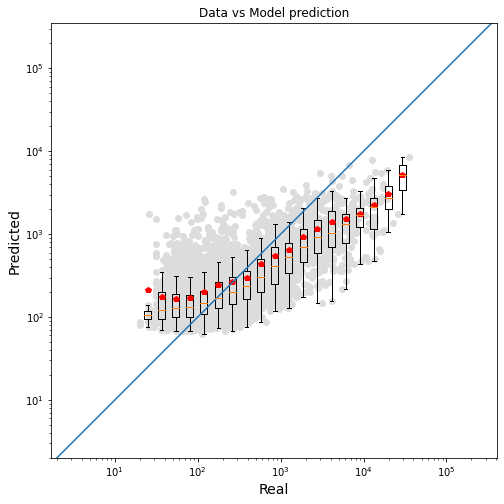

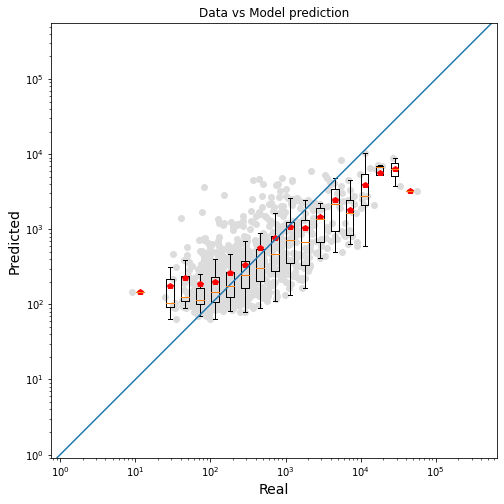

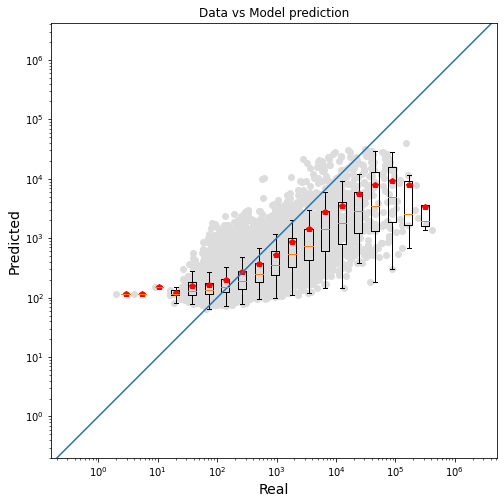

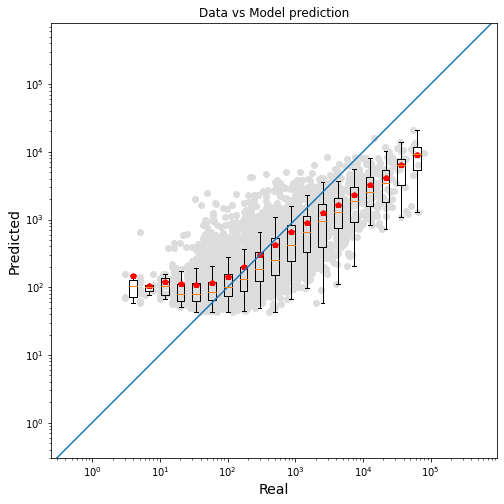

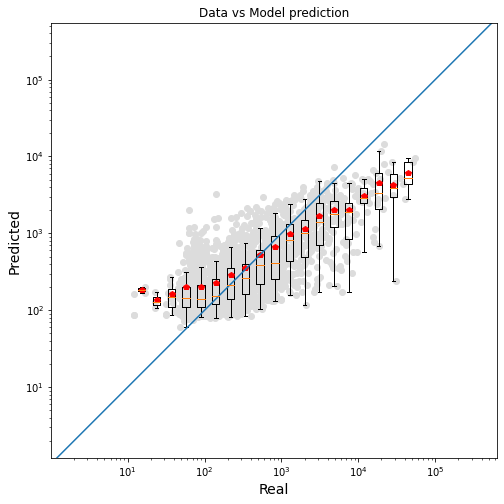

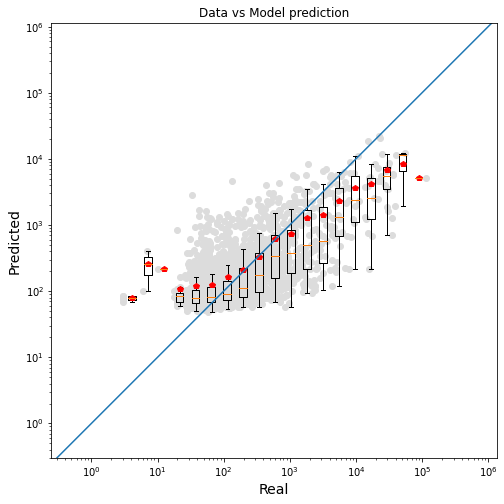

In [8]:
from sklearn.ensemble import RandomForestRegressor
res={}
# Features

for key,frame in train_list_dataframes.items():  

    # Features data
    feature_list = list(frame.drop(['total_pop_flow','name_o','name_d','s','sk','area_o','area_d'], axis = 1).columns)
    train_labels = np.log(np.array(frame['total_pop_flow']))
    train_features = np.array(frame.drop(['total_pop_flow','name_o','name_d','s','sk','area_o','area_d'], axis = 1))
    print('Flows and features Shape:', frame.shape)

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, n_jobs=3)
    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 6)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


    # Test Random Forest
    df=test_list_dataframes[key]
    test_labels = np.array(df['total_pop_flow'])
    test_features = np.array(df.drop(['total_pop_flow','name_o','name_d','s','sk','area_o','area_d'], axis = 1))
    predictions = np.exp(rf.predict(test_features))
    scatter_models[key]['Random Forest']=deepcopy(predictions)
    scatter_models[key]['test']=deepcopy(test_labels)
    
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              '-'
             ]
    error_models[key]['Random Forest']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    economic_stats[key]['Random Forest']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

RF = pd.DataFrame(res,index=[['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(RF)

### Computing natural logarithm of population flow

In [9]:
if log_flows==True:
    for i,frame in enumerate(list_states_dataframes):
        list_states_dataframes[i]['total_pop_flow']=list_states_dataframes[i]['total_pop_flow'].apply(lambda x : np.log(x))
    for i,df in enumerate(list_states_dataframes):
        #
        train_list_dataframes[states[i]]['total_pop_flow']=train_list_dataframes[states[i]]['total_pop_flow'].apply(lambda x : np.log(x))
        #
        x_train_list_sample[states[i]]['total_pop_flow']=x_train_list_sample[states[i]]['total_pop_flow'].apply(lambda x : np.log(x))
        #
        y_train_list_sample[states[i]]=y_train_list_sample[states[i]].apply(lambda x : np.log(x))
    log_scale=False
else:
    log_scale=True

## GRAVITY MODEL B $f(r)=r^\gamma$

{'d0': {'_a0_': -10.015526208615933, '_a2_': 1.2131055392295953}}
Model metrics:New York
CPC: 0.545334749977521
Acc: 0.542583247527905
RMSE: 1373.9406830935325
RE: 1.79885667878403
DL(train): 1.1269528257499606
{'d0': {'_a0_': -9.92953677527635, '_a2_': 1.3859246002335155}}
Model metrics:Massachusetts
CPC: 0.41197460194552216
Acc: 0.7016675547878448
RMSE: 6554.828820843713
RE: 4.117941448325636
DL(train): 1.4024000129633525
{'d0': {'_a0_': -11.502837799425405, '_a2_': 1.1155874773430452}}
Model metrics:California
CPC: 0.5376248326985041
Acc: 0.5576366934101374
RMSE: 10394.95793428726
RE: 2.143648594762072
DL(train): 1.2236491906606697
{'d0': {'_a0_': -10.248832027275393, '_a2_': 1.2457975988436847}}
Model metrics:Florida
CPC: 0.5483977019500001
Acc: 0.5914361938154119
RMSE: 3193.9784687801875
RE: 2.8090007388943006
DL(train): 1.3336731117226328
{'d0': {'_a0_': -9.78573875040831, '_a2_': 1.2018922337244198}}
Model metrics:Washington
CPC: 0.4299183156985803
Acc: 0.7578775889943021
RMSE: 

New York Massachusetts    California      Florida  \
Gravity pow CPC           0.545335      0.411975      0.537625     0.548398   
            ACC           0.542583      0.701668      0.557637     0.591436   
            RMSE       1373.940683   6554.828821  10394.957934  3193.978469   
            RE            1.798857      4.117941      2.143649     2.809001   
            LR            1.126953        1.4024      1.223649     1.333673   
            DL(train)     1983.229      1972.125      1928.847     1961.885   

                        Washington        Texas  
Gravity pow CPC           0.429918     0.468753  
            ACC           0.757878     0.413016  
            RMSE       9682.618478  3040.995888  
            RE            5.277263     1.936286  
            LR            1.363113     1.601212  
            DL(train)     2057.147     2107.322

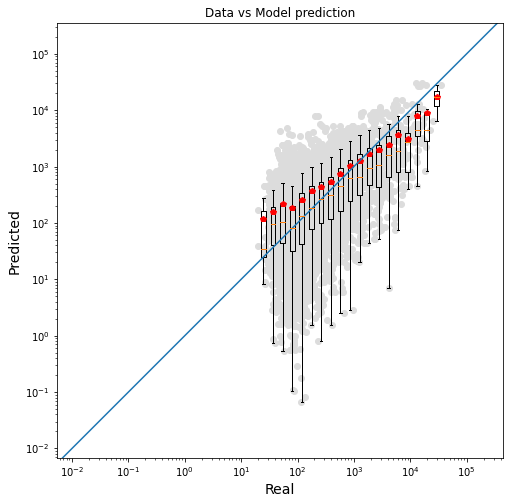

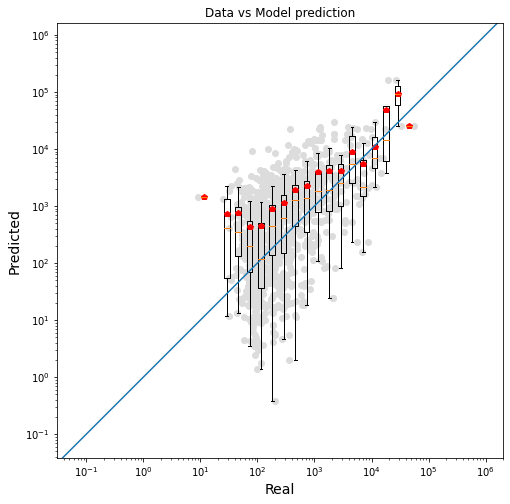

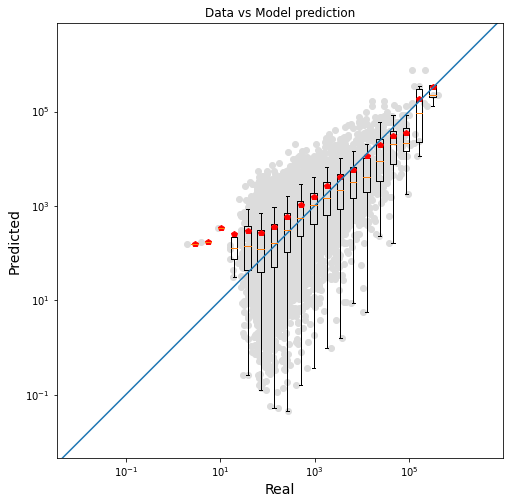

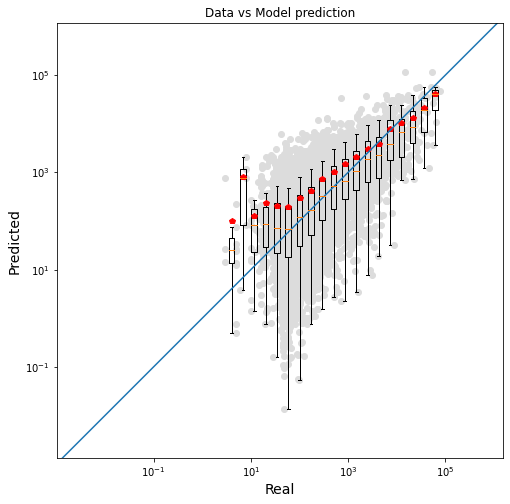

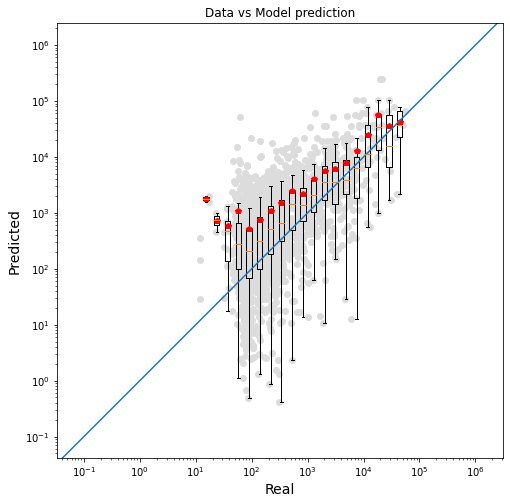

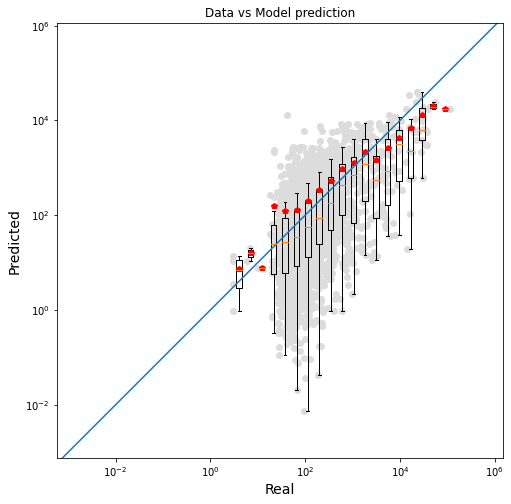

In [10]:
res={}
if log_flows==True:
    model='(_a0_ + ((log(m_o)) + ((log(m_d)) - (_a2_ * log(d)))))'
else:
    model = '(_a0_ * ((m_o * m_d) / (d ** _a1_)))'
for key,df in train_list_dataframes.items():
    gravity_model = ms.from_string_model(df,df.total_pop_flow,model,n_vars=3,n_params=3,silence=True)
    print(gravity_model.par_values)
    predictions = gravity_model.predict(test_list_dataframes[key])
    if log_flows==True:
        predictions=np.exp(predictions)
    test_labels=test_list_dataframes[key].total_pop_flow
    scatter_models[key]['Gravity pow']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              round(gravity_model.E,3)
             ]
    error_models[key]['Gravity pow']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['Gravity pow']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

G_pow = pd.DataFrame(res,index=[['Gravity pow', 'Gravity pow', 'Gravity pow', 'Gravity pow', 'Gravity pow', 'Gravity pow'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(G_pow)

## GRAVITY MODEL $f(r)=e^{\beta r}$

DL: 2071.46163478592
{'d0': {'_a0_': -13.252898082398827, '_a2_': 0.013759875809389591}}
Model metrics:New York
CPC: 0.40265829283662086
Acc: 0.33371446089448065
RMSE: 1647.2428003318935
RE: 2.0179006909559023
DL(train): 1.2419908106390576
DL: 2021.81320663902
{'d0': {'_a0_': -13.486709258025279, '_a2_': 0.028472916269986704}}
Model metrics:Massachusetts
CPC: 0.43937707043324803
Acc: 0.5516111487847145
RMSE: 2593.693383104669
RE: 4.207977167701996
DL(train): 1.4759826462883883
DL: 2091.84441392946
{'d0': {'_a0_': -15.410679910895155, '_a2_': 0.005028183303469876}}
Model metrics:California
CPC: 0.3669573682538795
Acc: 0.3831618671024355
RMSE: 11055.82838525928
RE: 3.595337430276864
DL(train): 1.4712898641572583
DL: 2078.18694544784
{'d0': {'_a0_': -14.125058964316532, '_a2_': 0.010719534588127013}}
Model metrics:Florida
CPC: 0.4027631111963184
Acc: 0.38173018991469376
RMSE: 3488.3140026656856
RE: 3.8448244702302583
DL(train): 1.574530803063575
DL: 2114.47641933768
{'d0': {'_a0_': -13.25

New York Massachusetts    California      Florida  \
Gravity exp CPC         0.402658      0.439377      0.366957     0.402763   
            ACC         0.333714      0.551611      0.383162      0.38173   
            RMSE       1647.2428   2593.693383  11055.828385  3488.314003   
            RE          2.017901      4.207977      3.595337     3.844824   
            LR          1.241991      1.475983       1.47129     1.574531   
            DL(train)   2071.462      2021.813      2091.844     2078.187   

                        Washington        Texas  
Gravity exp CPC           0.345156     0.297006  
            ACC           0.592198      0.23351  
            RMSE       9440.528799  3604.544373  
            RE            6.390728     2.326069  
            LR            1.526018     1.708558  
            DL(train)     2114.476     2188.453

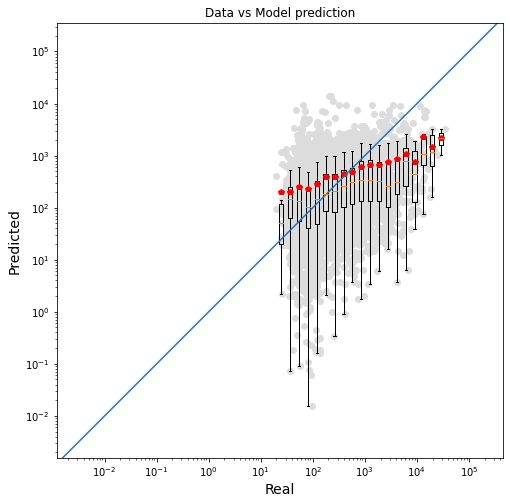

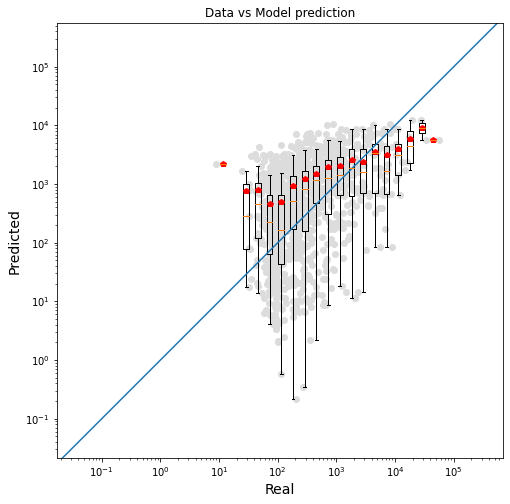

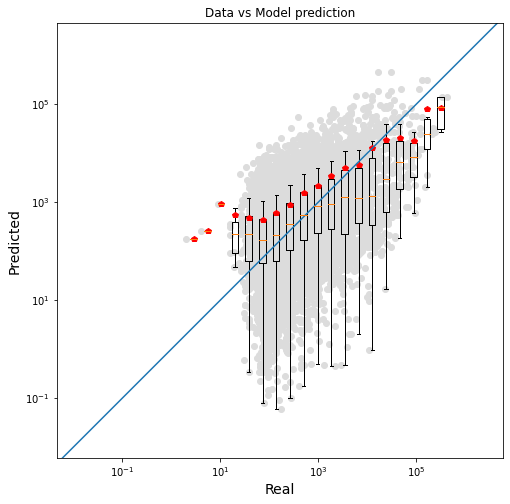

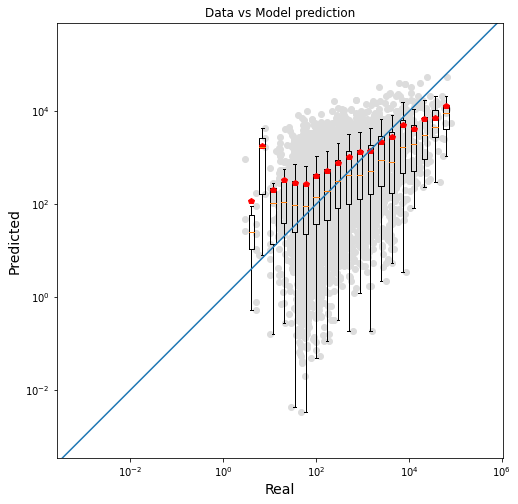

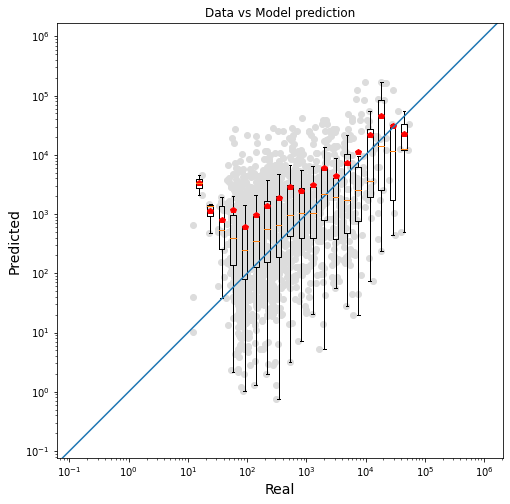

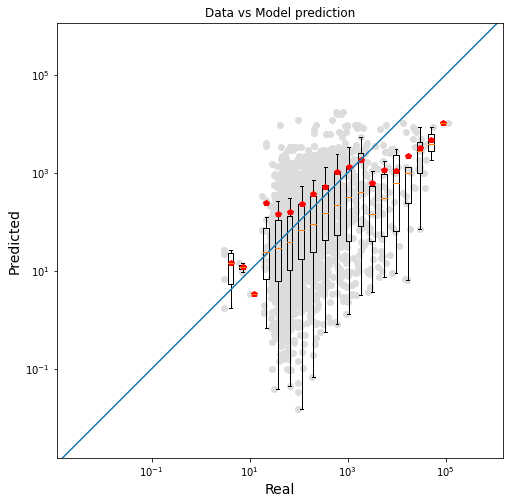

In [11]:
res={}
if log_flows==True:
    model='(_a0_ + ((log(m_o)) + ((log(m_d)) - (_a2_ * d))))'
else:
    model = '(_a0_ * ((m_o * m_d) / ( exp((d * _a1_)))))'
for key,df in train_list_dataframes.items():
    gravity_model = ms.from_string_model(df,df.total_pop_flow,model,n_vars=3,n_params=3,silence=True)
    print('DL:',gravity_model.E)
    print(gravity_model.par_values)
    predictions = gravity_model.predict(test_list_dataframes[key])
    if log_flows==True:
        predictions=np.exp(predictions)
    test_labels=test_list_dataframes[key].total_pop_flow
    scatter_models[key]['Gravity exp']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              round(gravity_model.E,3)
             ]
    error_models[key]['Gravity exp']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['Gravity exp']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

G_exp = pd.DataFrame(res,index=[['Gravity exp', 'Gravity exp', 'Gravity exp', 'Gravity exp', 'Gravity exp', 'Gravity exp'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR', 'DL(train)']])
display(G_exp)

# Machine Scientist

## BMS Plausible

Model metrics:New York
CPC: 0.550718977956788
Acc: 0.42999035792546186
RMSE: 1376.8729088865655
RE: 0.968741520540599
DL(train): 0.7301465667249422
Model metrics:Massachusetts
CPC: 0.543669605275689
Acc: 0.5362543500063811
RMSE: 3898.160922540932
RE: 1.138098760513705
DL(train): 0.7087833626211129
Model metrics:California
CPC: 0.025528289731534756
Acc: 0.6368683416950135
RMSE: 6452231.835771142
RE: 1.5246229113791008
DL(train): 0.7153949978619343
Model metrics:Florida
CPC: 0.5334959250943598
Acc: 0.4110212014616212
RMSE: 3051.214012726267
RE: 1.0251113559176415
DL(train): 0.7239990850236312
Model metrics:Washington
CPC: 0.5879811313617584
Acc: 0.5482739941110676
RMSE: 3620.966332803307
RE: 1.4407446817922478
DL(train): 0.7606581875548684
Model metrics:Texas
CPC: 0.5242531665735787
Acc: 0.40860219997995606
RMSE: 3190.540915544992
RE: 0.9232102156393586
DL(train): 0.700092522808488


New York Massachusetts      California  \
BMS Plausible CPC           0.550719       0.54367        0.025528   
              ACC            0.42999      0.536254        0.636868   
              RMSE       1376.872909   3898.160923  6452231.835771   
              RE            0.968742      1.138099        1.524623   
              LR            0.730147      0.708783        0.715395   
              DL(train)     8188.306      8188.306        8188.306   

                             Florida   Washington        Texas  
BMS Plausible CPC           0.533496     0.587981     0.524253  
              ACC           0.411021     0.548274     0.408602  
              RMSE       3051.214013  3620.966333  3190.540916  
              RE            1.025111     1.440745      0.92321  
              LR            0.723999     0.760658     0.700093  
              DL(train)     8188.306     8188.306     8188.306

CPU times: user 1.28 s, sys: 4.14 ms, total: 1.28 s
Wall time: 1.38 s


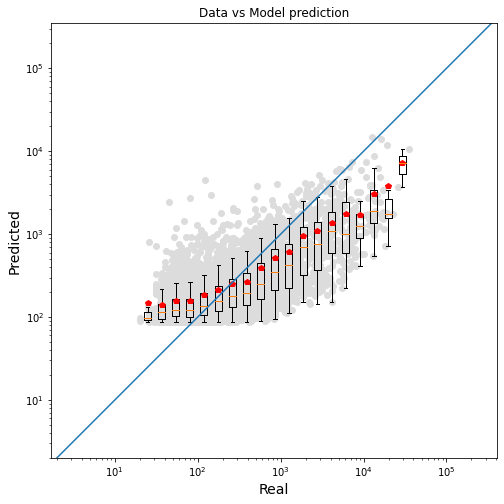

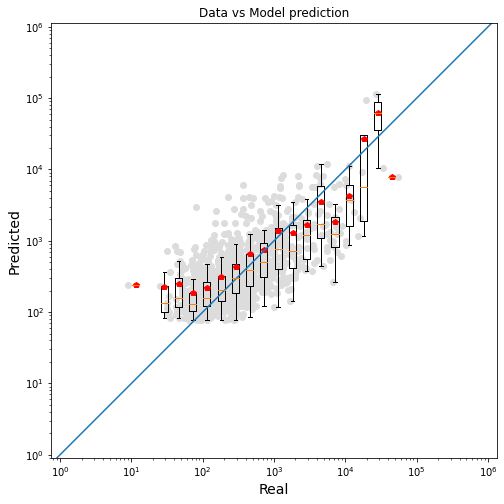

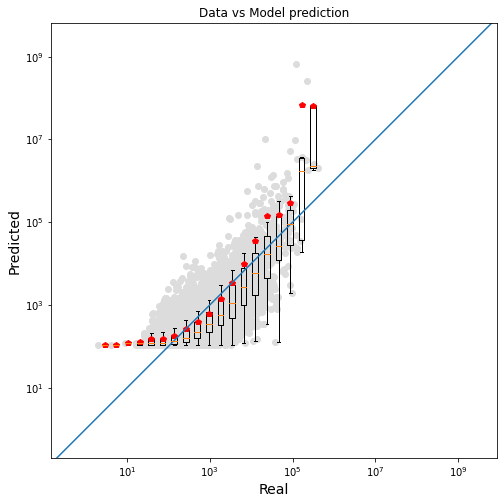

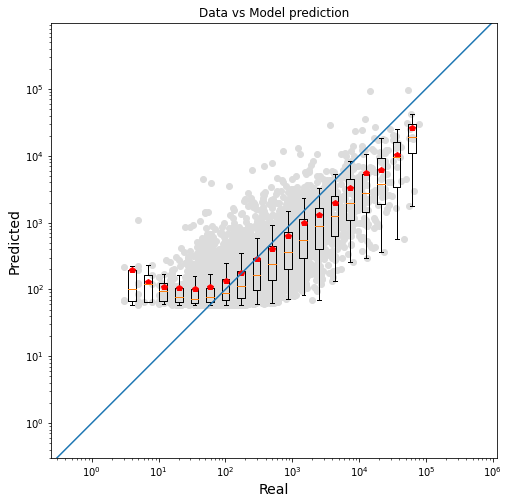

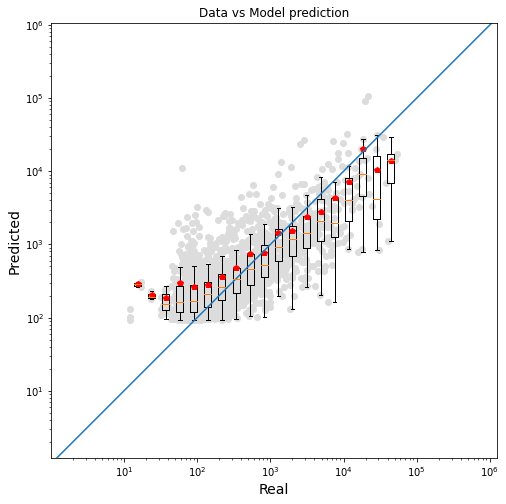

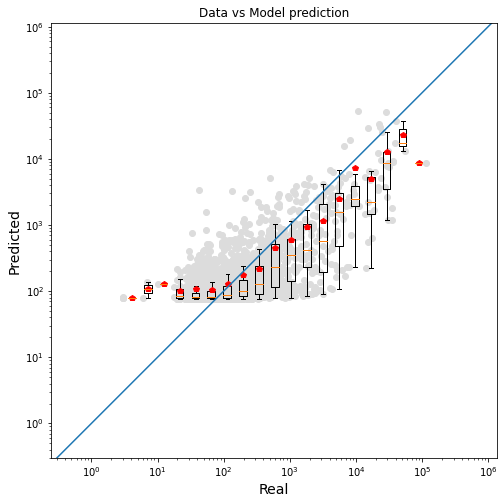

In [12]:
%%time
res={}

name=open('./data/checkpoints/fold1_state_model_C_2022_11_20-10_23_56.pkl', "rb")
best_model=pickle.load(name)
name.close()
name=open('./data/checkpoints/fold1_ensemble_model_C_2022_11_20-10_23_56.pkl', "rb")
state_ensemble=pickle.load(name)
name.close()


for key,frame in test_list_dataframes.items():
    predictions = best_model.predict({key:test_list_dataframes[key]})[key]
    if log_flows==True:
        predictions=np.exp(predictions)
    test_labels=test_list_dataframes[key].total_pop_flow
    scatter_models[key]['BMS Plausible']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              round(best_model.E,3)
             ]
    error_models[key]['BMS Plausible']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['BMS Plausible']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

BMS_plausible = pd.DataFrame(res,index=[['BMS Plausible', 'BMS Plausible', 'BMS Plausible', 'BMS Plausible', 'BMS Plausible','BMS Plausible'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(BMS_plausible)

## BMS Ensemble

5952
Model metrics:New York
CPC: 0.5477386506506507
Acc: 0.4288345442925219
RMSE: 1382.8129683565705
RE: 0.9842482958309041
DL(train): 0.7391620895670703
1180
Model metrics:Massachusetts
CPC: 0.44699793655489334
Acc: 0.5445074028000891
RMSE: 12226.148018987928
RE: 1.1580263189132196
DL(train): 0.7189733191797096
11727
Model metrics:California
CPC: 2.376673856328053e-13
Acc: 0.6483008459362795
RMSE: 1.0115348395296677e+18
RE: 79203319576.64362
DL(train): 0.7397714605574648
7092
Model metrics:Florida
CPC: 0.5057497435230789
Acc: 0.4501419333581123
RMSE: 8950.849023605662
RE: 1.035581334402554
DL(train): 0.7325157300355053
2083
Model metrics:Washington
CPC: 0.5728899082005717
Acc: 0.52546565119341
RMSE: 3999.5874078353577
RE: 1.4195202653241803
DL(train): 0.765984968736021
2782
Model metrics:Texas
CPC: 0.4887747240267337
Acc: 0.4057908312513242
RMSE: 4117.092122710685
RE: 0.9094660710107563
DL(train): 0.6988836356136499


New York Massachusetts             California  \
BMS Ensemble CPC           0.547739      0.446998                    0.0   
             ACC           0.428835      0.544507               0.648301   
             RMSE       1382.812968  12226.148019  1011534839529667712.0   
             RE            0.984248      1.158026     79203319576.643616   
             LR            0.739162      0.718973               0.739771   
             DL(train)            -             -                      -   

                            Florida   Washington        Texas  
BMS Ensemble CPC            0.50575      0.57289     0.488775  
             ACC           0.450142     0.525466     0.405791  
             RMSE       8950.849024  3999.587408  4117.092123  
             RE            1.035581      1.41952     0.909466  
             LR            0.732516     0.765985     0.698884  
             DL(train)            -            -            -

CPU times: user 3h 48min 50s, sys: 15.7 s, total: 3h 49min 5s
Wall time: 3h 49min 11s


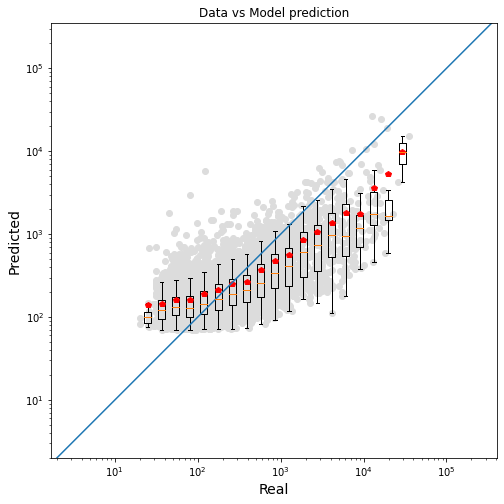

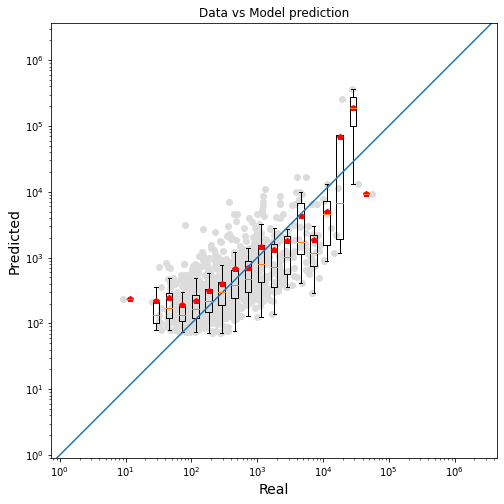

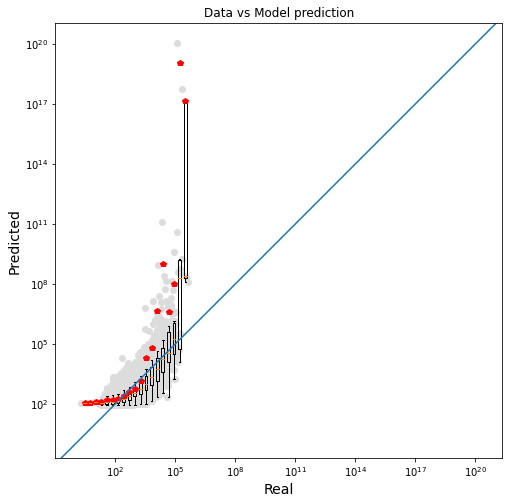

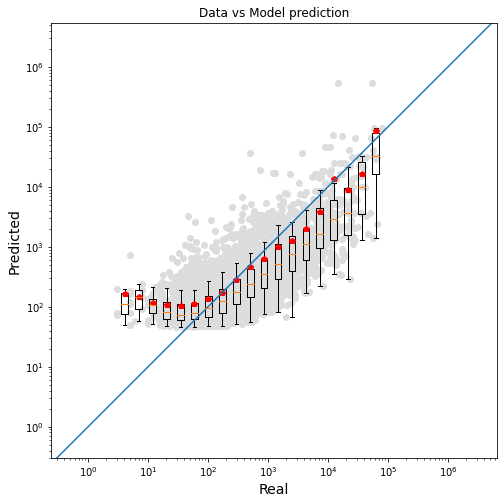

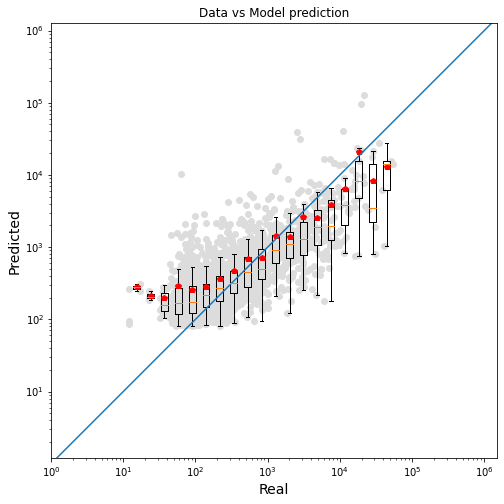

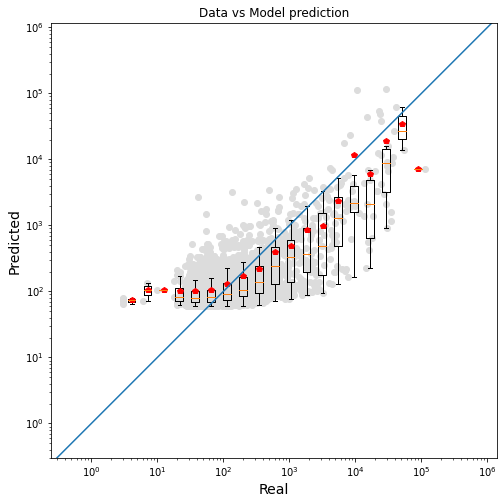

In [13]:
%%time
res={}
prediction_ensemble={}
for key,frame in x_train_list_sample.items():
    prediction_ensemble[key] = ensemble_prediction_median_multidf(state_ensemble,test_list_dataframes[key],key=key)
    test_labels=test_list_dataframes[key].total_pop_flow
    scatter_models[key]['BMS Ensemble']=deepcopy(prediction_ensemble[key])
    print(len(prediction_ensemble[key]))
    res[key]=[common_part_of_commuters(test_labels,prediction_ensemble[key]),
              common_part_of_commuters_accuracy(test_labels,prediction_ensemble[key]),
              RMSE(test_labels,prediction_ensemble[key]),
              MRE(test_labels,prediction_ensemble[key]),
              MLogRatio(test_labels,prediction_ensemble[key]),
              '-'
             ]
    
    error_models[key]['BMS Ensemble']={'AbsErr':deepcopy(AbsErr(test_labels,prediction_ensemble[key])),
                                          'RE':deepcopy(RE(test_labels,prediction_ensemble[key])),
                                          'LogRatio':deepcopy(LogRatio(test_labels,prediction_ensemble[key]))
                                         }
    
    economic_stats[key]['BMS Ensemble']=prediction_ensemble[key]
    
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,prediction_ensemble[key])
    try:
        ms.plot_predicted_model(prediction=prediction_ensemble[key],real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)
    except:
        print('Plot error')
            
BMS_ensemble = pd.DataFrame(res,index=[['BMS Ensemble', 'BMS Ensemble', 'BMS Ensemble', 'BMS Ensemble', 'BMS Ensemble','BMS Ensemble'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(BMS_ensemble)

## BMS Predictive

log((((((((m_o + _a4_) + d) * (-((d ** _a3_)) * ((((_a0_ / m_o) + (_a1_ ** 2)) + m_d) + m_d))) * ((_a0_ + m_d) * _a5_)) / (_a3_ / _a0_)) * _a0_) + abs(_a1_)))
log((((((((m_o + _a4_) + d) * (-((d ** _a3_)) * ((((_a0_ / m_o) + (_a1_ ** 2)) + m_d) + m_d))) * ((_a0_ + m_d) * _a5_)) / (_a3_ / _a0_)) * _a0_) + abs(_a1_)))
log((((((_a3_ * ((-((_a1_ / -(-(_a0_)))) / (d ** _a4_)) / log(d))) / m_d) + ((_a3_ * ((_a1_ + m_o) + _a2_)) * ((log(m_o) * d) ** _a0_))) * (m_d * _a3_)) ** (_a5_ ** 2)))
log((((((((m_o + _a4_) + d) * (-((d ** _a3_)) * ((((_a0_ / m_o) + (_a1_ ** 2)) + m_d) + m_d))) * ((_a0_ + m_d) * _a5_)) / (_a3_ / _a0_)) * _a0_) + abs(_a1_)))
log((((((_a3_ * ((-((_a1_ * -(_a5_))) / (d ** _a4_)) / log(d))) / m_d) + ((_a3_ * ((_a1_ + m_o) + _a2_)) * ((log(m_o) * d) ** _a0_))) * (m_d * _a3_)) ** (_a5_ * _a5_)))
log((((((((m_o + _a4_) + d) * (-((d ** _a3_)) * (((((_a0_ * d) / m_o) + (_a1_ ** 2)) + m_d) + m_d))) * (((_a1_ * _a2_) + m_d) * _a5_)) / (_a3_ / _a0_)) * _a4_) + abs(_a1_)))
((((((((d 

(((((((((_a1_ * _a4_) * ((_a1_ ** 2) ** 2)) * (_a4_ * _a1_)) ** 2) * (_a1_ ** 2)) / _a5_) / (_a4_ + -(((sqrt(((sqrt(m_d) ** tan(_a4_)) * (_a3_ + m_o))) + _a1_) / d)))) * _a1_) + _a0_)
(((((((((_a1_ * _a4_) * ((_a1_ ** 2) ** 2)) * (_a4_ * _a1_)) ** 2) * (_a1_ ** 2)) / _a5_) / (_a4_ + -(((sqrt(((sqrt(m_d) ** tan(_a4_)) * (_a3_ + m_o))) + _a1_) / d)))) * _a1_) + _a0_)
log(((((((((m_d * (_a3_ * _a3_)) * m_o) + _a4_) + m_d) * ((((m_d * _a4_) ** (d / _a4_)) / (_a2_ + ((_a0_ * ((_a1_ + (d * _a5_)) + _a1_)) * d))) / (_a5_ * d))) ** _a0_) ** 2) + _a1_))
log(((((((((m_d * (_a3_ * _a3_)) * m_o) + _a4_) + m_d) * ((((m_d * _a4_) ** (d / _a4_)) / (_a2_ + ((_a0_ * ((_a1_ * _a3_) + _a1_)) + d))) / (_a5_ * d))) ** _a0_) ** 2) + _a1_))
(((((((((_a1_ * _a4_) * ((_a1_ ** 2) ** 2)) * ((_a3_ + _a4_) * _a1_)) ** 2) * (_a1_ ** 2)) / _a5_) / (_a4_ + -(((sqrt(((sqrt(m_d) ** tan(_a4_)) * (_a3_ + m_o))) + _a1_) / d)))) * _a1_) + _a0_)
(((((((((_a1_ * _a4_) * ((_a1_ ** 2) ** 2)) * ((_a4_ ** 2) * _a1_)) ** 2) * (_a

log(((((((_a4_ ** 2) ** 2) * d) * (d / ((_a2_ * d) + (((m_o + _a3_) / _a3_) * (((_a4_ + m_d) * m_d) * abs((_a0_ + _a1_))))))) ** _a0_) + sqrt(_a3_)))
log(((((((_a4_ ** 2) ** 2) * d) * (d / ((_a2_ * d) + (((m_o + _a3_) / _a3_) * (((_a4_ + m_d) * m_d) * abs(_a1_)))))) ** _a0_) + sqrt(_a3_)))
(((((_a5_ * (((((m_o + _a0_) + _a0_) * (m_d + (_a5_ * _a4_))) ** _a5_) / d)) * _a1_) + _a4_) * (cos((_a5_ + (_a0_ * (_a1_ / _a1_)))) ** 2)) ** _a1_)
Model metrics:New York
CPC: 0.5479031686671949
Acc: 0.4290761311792769
RMSE: 1382.4405465089449
RE: 0.9847586680543832
DL(train): 0.7391881037099421
Model metrics:Massachusetts
CPC: 0.44763218680389893
Acc: 0.5451168625411604
RMSE: 12177.287731333643
RE: 1.1589576488091
DL(train): 0.7192211009874024
Model metrics:California
CPC: 6.107446730832803e-13
Acc: 0.6461816273069755
RMSE: 3.921514685723327e+17
RE: 30713562121.874046
DL(train): 0.7381132978622763
Model metrics:Florida
CPC: 0.5056032627795725
Acc: 0.4488942852305847
RMSE: 8839.844749271071
RE: 1.03

New York Massachusetts            California  \
BMS Predictive CPC           0.547903      0.447632                   0.0   
               ACC           0.429076      0.545117              0.646182   
               RMSE       1382.440547  12177.287731  392151468572332672.0   
               RE            0.984759      1.158958    30713562121.874046   
               LR            0.739188      0.719221              0.738113   
               DL(train)     8233.183      8233.183              8233.183   

                              Florida   Washington        Texas  
BMS Predictive CPC           0.505603      0.57374     0.488661  
               ACC           0.448894     0.521728     0.405755  
               RMSE       8839.844749  3835.987889  4121.170045  
               RE            1.034291     1.413695     0.909534  
               LR            0.732794     0.765608     0.698942  
               DL(train)     8233.183     8233.183     8233.183

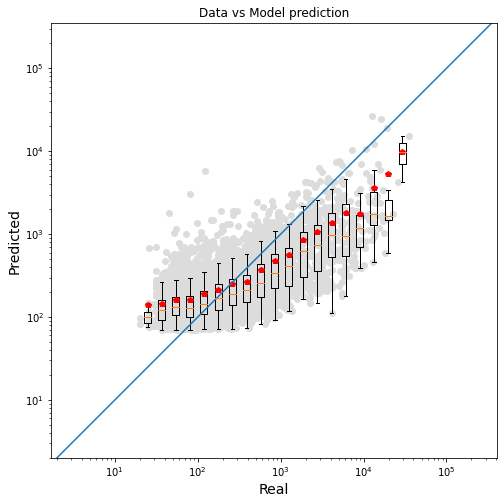

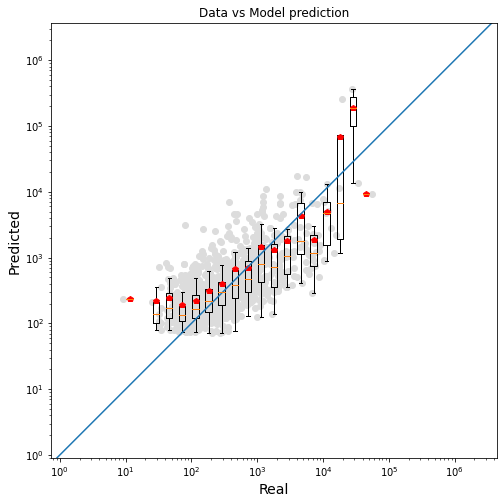

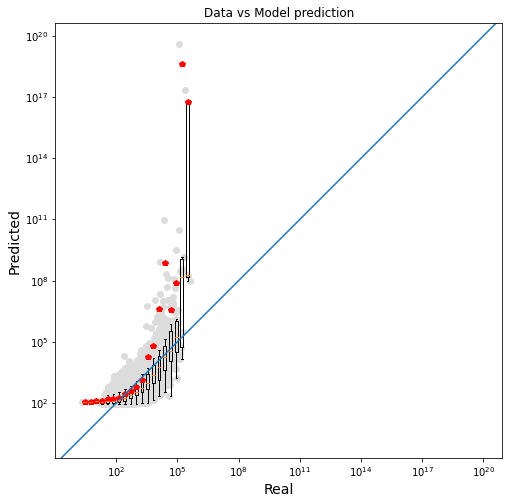

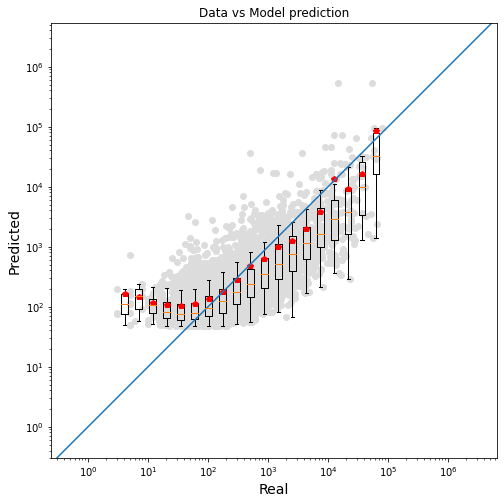

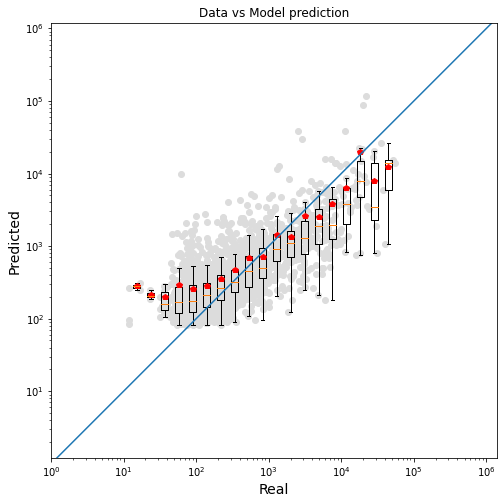

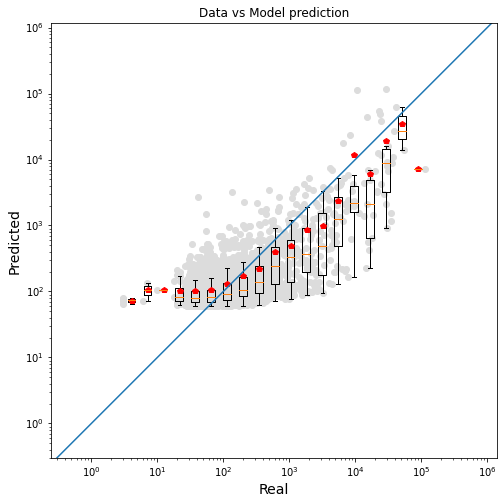

In [14]:
res={}
model_re_ensemble={}
pred_ens=[]
for i in prediction_ensemble.values():
    pred_ens=np.concatenate([pred_ens,i])

    #prediction_ensemble=ensemble_prediction_median(state_ensemble,deepcopy(test_list_dataframes[key]))
    # Model dl closest to median_models_dl
lowest_diff=np.inf
for m in state_ensemble:
    print(m)
    pred=[]
    new_prediction=m.predict(test_list_dataframes)
    for key in states:
        if log_flows==True:
            new_prediction[key]=np.exp(new_prediction[key])
        pred=np.concatenate([pred,new_prediction[key]])
    diff=MRE(pred_ens,pred)
    if diff<lowest_diff:
        lowest_diff_model=deepcopy(m)
        print(lowest_diff_model)
        lowest_diff=diff
model_re_ensemble=deepcopy(lowest_diff_model)
print(str(lowest_diff_model))
# Predictions with model close to median_models_dl
predictions_dict=model_re_ensemble.predict(test_list_dataframes)
for key,prediction in predictions_dict.items():
    if log_flows==True:
        predictions=np.exp(prediction)
    else:
        predictions=prediction
    test_labels=test_list_dataframes[key].total_pop_flow
    scatter_models[key]['BMS Predictive']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              round(lowest_diff_model.E,3)
             ]
    error_models[key]['BMS Predictive']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    
    economic_stats[key]['BMS Predictive']=predictions

    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)
    try:
        ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)
    except:
        print('Plot error')
            
BMS_predictive = pd.DataFrame(res,index=[['BMS Predictive', 'BMS Predictive', 'BMS Predictive', 'BMS Predictive', 'BMS Predictive','BMS Predictive'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(BMS_predictive)

### Results

In [15]:
df=pd.concat([DG,RF,G_pow,G_exp,Rad,BMS_plausible,BMS_ensemble,BMS_predictive])
display(df)
"""
name=f'./data/checkpoints/df_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
df.to_pickle(name)
print(name)
name=f'./data/checkpoints/scatter_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(scatter_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
name=f'./data/checkpoints/error_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(error_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
name=f'./data/checkpoints/economic_stats_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl'
with open(name, 'wb') as handle:
    pickle.dump(economic_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(name)
"""

New York Massachusetts             California  \
Deep Gravity   CPC           0.527666      0.494646               0.566735   
               ACC           0.377561      0.336927               0.452098   
               RMSE       1270.988892   1908.802856            7224.522461   
               RE            0.753854       0.69622               0.986685   
               LR            1.338477      1.327223               1.584433   
               DL(train)            -             -                      -   
Random Forest  CPC           0.549172      0.573138               0.401553   
               ACC           0.434492      0.475632               0.267174   
               RMSE       1404.533689   2268.421804            8935.178404   
               RE            1.087817       0.98392               0.826701   
               LR            0.726177      0.669719               0.750441   
               DL(train)            -             -                      -   
Gravity pow    CPC           0.545335      0.411975               0.537625   
               ACC           0.542583      0.701668               0.557637   
               RMSE       1373.940683   6554.828821           10394.957934   
               RE            1.798857      4.117941               2.143649   
               LR            1.126953        1.4024               1.223649   
               DL(train)     1983.229      1972.125               1928.847   
Gravity exp    CPC           0.402658      0.439377               0.366957   
               ACC           0.333714      0.551611               0.383162   
               RMSE         1647.2428   2593.693383           11055.828385   
               RE            2.017901      4.207977               3.595337   
               LR            1.241991      1.475983                1.47129   
               DL(train)     2071.462      2021.813               2091.844   
Radiation      CPC           0.429532       0.55605               0.491958   
               ACC           0.454441      0.593662               0.452832   
               RMSE       2968.750739   2701.943388            8400.231715   
               RE            1.250461      1.205045               1.282768   
               LR            2.953882      1.972991               2.913085   
               DL(train)            -             -                      -   
BMS Plausible  CPC           0.550719       0.54367               0.025528   
               ACC            0.42999      0.536254               0.636868   
               RMSE       1376.872909   3898.160923         6452231.835771   
               RE            0.968742      1.138099               1.524623   
               LR            0.730147      0.708783               0.715395   
               DL(train)     8188.306      8188.306               8188.306   
BMS Ensemble   CPC           0.547739      0.446998                    0.0   
               ACC           0.428835      0.544507               0.648301   
               RMSE       1382.812968  12226.148019  1011534839529667712.0   
               RE            0.984248      1.158026     79203319576.643616   
               LR            0.739162      0.718973               0.739771   
               DL(train)            -             -                      -   
BMS Predictive CPC           0.547903      0.447632                    0.0   
               ACC           0.429076      0.545117               0.646182   
               RMSE       1382.440547  12177.287731   392151468572332672.0   
               RE            0.984759      1.158958     30713562121.874046   
               LR            0.739188      0.719221               0.738113   
               DL(train)     8233.183      8233.183               8233.183   

                              Florida   Washington        Texas  
Deep Gravity   CPC           0.623739     0.548155     0.449948  
               ACC           0.516291     0.441392     0.306067  
        

'\nname=f\'./data/checkpoints/df_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl\'\ndf.to_pickle(name)\nprint(name)\nname=f\'./data/checkpoints/scatter_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl\'\nwith open(name, \'wb\') as handle:\n    pickle.dump(scatter_models, handle, protocol=pickle.HIGHEST_PROTOCOL)\nprint(name)\nname=f\'./data/checkpoints/error_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl\'\nwith open(name, \'wb\') as handle:\n    pickle.dump(error_models, handle, protocol=pickle.HIGHEST_PROTOCOL)\nprint(name)\nname=f\'./data/checkpoints/economic_stats_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S")}.pkl\'\nwith open(name, \'wb\') as handle:\n    pickle.dump(economic_stats, handle, protocol=pickle.HIGHEST_PROTOCOL)\nprint(name)\n'